In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

%matplotlib inline

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effi_process_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Dense, Flatten
model_name = 'EfficientNetB0'

In [3]:
image_size = 224 
batch_size = 32
init_lr = 0.0_001
num_epochs = 20

!mkdir './EfficientNetB0'
save_MobileNet = './EfficientNetB0/'

## Load Dataset

In [4]:
dir_name = '../input/face-mask-12k-images-dataset/Face Mask Dataset/' 

train_path = os.path.join(dir_name, 'Train')
train_mask_path = os.path.join(dir_name, 'WithMask')
train_no_mask_path = os.path.join(dir_name, 'WithOutMask')

test_path = os.path.join(dir_name, 'Test')
test_mask_path = os.path.join(dir_name, 'WithMask')
test_no_mask_path = os.path.join(dir_name, 'WithOutMask')

val_path = os.path.join(dir_name, 'Validation')
val_mask_path = os.path.join(dir_name, 'WithMask')
val_no_mask_path = os.path.join(dir_name, 'WithOutMask')

## Preprocessing Dataset

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                  zoom_range = 0.2,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  shear_range = 0.15, 
                                  fill_mode = 'nearest',
                                  horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   target_size = (image_size, image_size))

validation_generator = test_datagen.flow_from_directory(test_path,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 target_size = (image_size, image_size))

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## Model

In [7]:
efficientNet_base = EfficientNetB0(include_top=False, pooling=None, input_shape=(image_size, image_size, 3))

inner = efficientNet_base.output

inner = AveragePooling2D(pool_size=(7, 7))(inner)
inner = Flatten()(inner)
inner = Dense(units=256, activation='relu')(inner)
inner = Dropout(0.2)(inner)
inner = Dense(units=2, activation='softmax')(inner)

model = Model(inputs=efficientNet_base.input, outputs=inner)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
______________________________________________________________________________________________

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=init_lr, decay=init_lr / num_epochs),
              metrics=[Recall(name='recall'), 
                       'accuracy', 
                       Precision(name='precision')])

In [10]:
model_save_callback = ModelCheckpoint(filepath='./model-epoch{epoch:03d}-recall-{val_recall:.3f}-acc-{val_accuracy:.3f}.h5',
                                     monitor='val_recall', mode='max', 
                                     verbose=1, save_best_only=False, save_weights_only=True)

early_stop_callback = EarlyStopping(monitor='val_recall',  min_delta=0, patience=15, verbose=1, mode='max')

In [11]:
history = model.fit(train_generator,
                    steps_per_epoch=10000 // batch_size,
                    validation_data=validation_generator,
                    validation_steps=992 // batch_size,
                    epochs=num_epochs,
                    callbacks=[model_save_callback, early_stop_callback],
                    verbose=1)

Epoch 1/20
312/312 [==============================] - 191s 574ms/step - loss: 0.1818 - recall: 0.9266 - accuracy: 0.9266 - precision: 0.9266 - val_loss: 0.8457 - val_recall: 0.4839 - val_accuracy: 0.4839 - val_precision: 0.4839

Epoch 00001: saving model to ./model-epoch001-recall-0.484-acc-0.484.h5
Epoch 2/20
312/312 [==============================] - 129s 413ms/step - loss: 0.0204 - recall: 0.9927 - accuracy: 0.9927 - precision: 0.9927 - val_loss: 0.5029 - val_recall: 0.7419 - val_accuracy: 0.7419 - val_precision: 0.7419

Epoch 00002: saving model to ./model-epoch002-recall-0.742-acc-0.742.h5
Epoch 3/20
312/312 [==============================] - 128s 412ms/step - loss: 0.0116 - recall: 0.9971 - accuracy: 0.9971 - precision: 0.9971 - val_loss: 0.5783 - val_recall: 0.7409 - val_accuracy: 0.7409 - val_precision: 0.7409

Epoch 00003: saving model to ./model-epoch003-recall-0.741-acc-0.741.h5
Epoch 4/20
312/312 [==============================] - 130s 416ms/step - loss: 0.0035 - recall: 0.

In [12]:
model.save('efficientNetB0_model.h5')

## Evaluate Model

In [13]:
import pandas as pd

train_stats = pd.DataFrame(history.history)

train_stats.sort_values(by=['val_recall'], inplace=False, ascending=False)

,loss,recall,accuracy,precision,val_loss,val_recall,val_accuracy,val_precision
13,0.001543,0.999398,0.999398,0.999398,0.009813,0.996976,0.996976,0.996976
14,0.000788,0.999699,0.999699,0.999699,0.011158,0.996976,0.996976,0.996976
9,0.001261,0.999599,0.999599,0.999599,0.041054,0.987903,0.987903,0.987903
11,0.003498,0.999197,0.999197,0.999197,0.258262,0.898185,0.898185,0.898185
16,0.000782,0.999599,0.999599,0.999599,0.702742,0.811492,0.811492,0.811492
1,0.017285,0.994081,0.994081,0.994081,0.502949,0.741935,0.741935,0.741935
2,0.007232,0.998094,0.998094,0.998094,0.578308,0.740927,0.740927,0.740927
4,0.007658,0.997191,0.997191,0.997191,0.787622,0.740927,0.740927,0.740927
10,0.001261,0.999398,0.999398,0.999398,13.082441,0.653226,0.653226,0.653226
3,0.003921,0.998796,0.998796,0.998796,1.415614,0.549395,0.549395,0.549395


<AxesSubplot:>

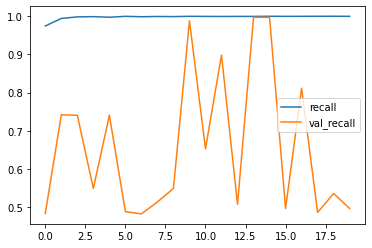

In [14]:
train_stats.plot(y=['recall', 'val_recall'], kind='line')

<AxesSubplot:>

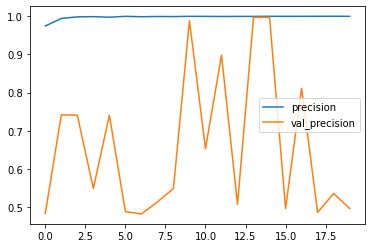

In [15]:
train_stats.plot(y=['precision', 'val_precision'], kind='line')

<AxesSubplot:>

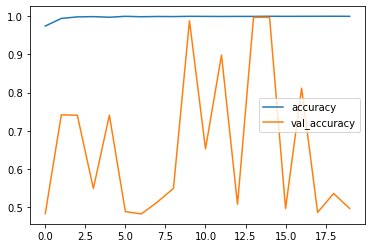

In [16]:
train_stats.plot(y=['accuracy', 'val_accuracy'], kind='line')

<AxesSubplot:>

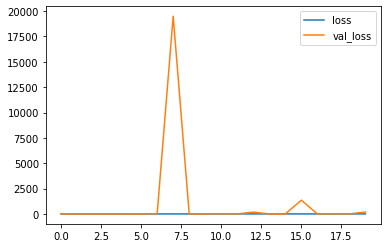

In [17]:
train_stats.plot(y=['loss', 'val_loss'], kind='line')

In [18]:
from sklearn.metrics import classification_report

target_names = []

for key in train_generator.class_indices:
    target_names.append(key)

Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Classification Report
              precision    recall  f1-score   support

    WithMask       0.40      0.02      0.03       483
 WithoutMask       0.51      0.98      0.67       509

    accuracy                           0.51       992
   macro avg       0.46      0.50      0.35       992
weighted avg       0.46      0.51      0.36       992



In [19]:
img_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithMask/1002.png'
img = image.load_img(img_path, target_size = (image_size, image_size, 3))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model.predict(img)

array([[0., 1.]], dtype=float32)

In [20]:
img_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/1016.png'
img = image.load_img(img_path, target_size = (image_size, image_size, 3))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model.predict(img)

array([[0., 1.]], dtype=float32)